<a href="https://colab.research.google.com/github/Roxoner44/CalidadSoftware/blob/main/Diferentes%20Pruebas/Prueba_Balanceado_182.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prueba de ejecución con el dataet balanceado

Para esta ejecucion del modelo vamos a balancear el modelo "a la baja" reduciendo todos las clases al mismo numero de elementos, siendo este el numero de elementos que tenga la clase con menos imagenes.

#Importar Librerías

In [1]:
from google.colab import drive
#Montamos el drive en el directorio /content/drive
drive.mount("/content/drive")

%pip install -q -U keras-tuner
import tensorflow as tf
from tensorflow import keras

#KERAS
from keras import Sequential
from keras import models
from keras import layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, BatchNormalization
from keras import optimizers

#UTILS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

print(tf.__version__)


Mounted at /content/drive
     |████████████████████████████████| 135 kB 6.6 MB/s 
     |████████████████████████████████| 1.6 MB 48.3 MB/s 
2.9.2


In [2]:
#El camino donde tengo las celulas y donde voy a guardar los resultados son distintos
CELULASPATH = "/content/drive/My Drive/cérvix - proyecto/Celulas"
RESULTADOSPATH ="/content/drive/MyDrive/ucam/Investigación/resultados"

!ls "$CELULASPATH"
!ls "$RESULTADOSPATH"

#El tamaño del batch lo podemos modificar más adelante, deberíamos tambien comprobar el numero de elementos que tiene el dataset
batch_size = 32
img_height = 224
img_width = 224
seed = 42

entrenamiento  test


#Mostrar Imagenes

In [3]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

def mostrarConLabel(image_arr):
    x,y = image_arr.next()
    for i in range(0,3):
      image = x[i]
      label = y[i]
      print (label)
      plt.imshow(image)
      plt.show()

def mostrarConLabelMejor(image_arr,class_names):
  x,y = image_arr.next()
  plt.figure(figsize=(20,20))
  for i in range(10):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i])
      for j in range(4):
         if(y[i][j]==1): break
      plt.title(class_names[j])
      
  plt.show()

#Cargar datos Como dataframe

In [4]:
def cargarDataframeBinario(data):
  """
  Función que carga el dataframe con dos clases (benigna y altogrado) en lugar de con las clases originales

  Parameters:
    data (posixPath): path desde donde vamos a cargar las imagenes

  Returns:
    pandasDataframe: dataframe que contiene dos columnas (path y category) con todos los paths de las imagenes y sus categorias en formato binario (label encoding)

  """
  #Guardamos todos los paths que existen en el directorio que queremos
  lst = list(data.glob("*/*.tiff"))
  #Cramos una nueva lista
  newLst = list() 
  #Para cada elemento de la lista de paths (Por cada imagen)
  for l in lst:
      #Si el directorio en el que se encuentra es "benigna" significa que la celula no es revisable
      if l.parent == data / "benigna":
        tipo="No Revisable"
      #El resto son revisables
      else:
        tipo="Revisable"
      #Añade en la lista el tipo y el path de la imagen
      newLst.append((str(l),tipo))
  #Devuelve el dataframe generado a partir de la lista
  return  pd.DataFrame(newLst, columns = ['path', 'category'])

def cargarDataFrameCuatroClases(data):
  """
  Función que carga el dataframe con las clases originales

  Parameters:
    data (posixPath): path desde donde vamos a cargar las imagenes

  Returns:
    pandasDataframe: dataframe que contiene dos columnas (path y category) con todos los paths de las imagenes y sus categorias en formato binario (label encoding)

  """
  #Guardamos todos los paths que existen en el directorio que queremos
  lst = list(data.glob("*/*.tiff"))
  #Cramos una nueva lista
  newLst = list() 
  #Para cada elemento de la lista de paths (Por cada imagen)
  for l in lst:
    #Guarda el tipo como el nombre del directorio en el que se encuentra
    tipo=l.parent.name
     #Añade en la lista el tipo y el path de la imagen
    newLst.append((str(l),tipo)) #Devuelve el dataframe generado a partir de la lista
  return  pd.DataFrame(newLst, columns = ['path', 'category'])

#Funciones para mostrar los datos de la ejecución

In [5]:
#Recibe el history generado
def mostrarGrafico(history):
  acc      = history.history['accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs    = range(1,len(acc)+1,1) # obtener número de epochs

  plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
  plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
  plt.title ('Training and validation accuracy')
  plt.ylabel('acc')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()

  plt.plot  ( epochs,     loss, 'r--' , label="Training Loss")
  plt.plot  ( epochs, val_loss ,  'b', label="Validation loss")
  plt.title ('Training and validation loss'   )
  plt.ylabel('loss')
  plt.xlabel('epochs')

  plt.legend()
  plt.figure()
  plt.show()
def mostrarMatrizConf(test_predict,test_generator, class_names):
  
  predict = []

  for i in test_predict:
    predict.append(int(np.argmax(i)))

  predict = np.asarray(predict)

  accuracy = accuracy_score(test_generator.classes, np.asarray(predict))
  print(accuracy)

  cm = confusion_matrix(test_generator.classes, predict)

  cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names,)

  cm_display.plot(cmap = 'YlOrRd' )
  plt.show()

  #plt.figure(figsize = (10,10))
  #sns.heatmap(cm, annot=True, cmap='YlGn', xticklabels=class_names, yticklabels=class_names)
  #plt.show()
def calcularHistorial(model,history,validation_generator,test_generator,validation_steps):

  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch))+1
  print('Mejor epoca: %d' % (best_epoch,))

  eval_result = model.evaluate(validation_generator, steps =validation_steps, verbose =1)
  
  print("[test loss, test accuracy]:", eval_result)
  test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)
  class_names = list(validation_generator.class_indices.keys())
  mostrarMatrizConf(test_predict,test_generator,class_names)
  mostrarGrafico(history)


#Cargar los datos de forma dinamica

A pesar de conocer el numero de elementos de la clase más pequeña de antemano (182 -> bajogrado) vamos a hacer que se cargen de forma automatica por si en algun momento este numero cambia por alguna razon

##Nivelar el dataframe

Para esta prueba vamos a usar un codigo similar al que usamos para cargar las imagenes en el dataframe pero cargando solo las imagenes necesarias, calculando la carpeta con menos datos con anterioridad.

Adeamas vamos a separar ahora el validation split para que coja el mismo numero de imagenes para cada una de las clases

In [8]:
import random
#mantenemos la misma seed para que siempre cargue las mismas imagenes
random.seed(seed)
#primero contamos los elementos en cada carpeta, para eso usamos data.glob
#Guardamos el path en el cual se encuentran las imagenes de entrenamiento
data_train = pathlib.Path(CELULASPATH + "/entrenamiento")
#Guardamos el path en el cual se encuentran las imagenes de test
data_test= pathlib.Path(CELULASPATH + "/test")

#vamos a guardar el tamaño de cada clase en la siguiente lista
num_clases = list()
directorios =  data_train.glob("*/")
#usando ("*/") hacemos un recorrido por todas las carpetas o directorios
for directorio in directorios:
  #comprobamos que los coge bien
  # print(directorio)
  num_clases.append(len(list(directorio.glob('*'))))

#comprobamos el numero de imagenes en cada clase
print(num_clases)
#comprobamos la minima clase
min_class = np.min(num_clases)
validation_size = round(min_class*0.1)
print(min_class," ", validation_size*4," validacion")

df_train = pd.DataFrame(columns = ['path', 'category'])
df_validation = pd.DataFrame(columns = ['path', 'category'])

directorios = data_train.glob("*/")

for directorio, num_clase in zip(directorios, num_clases):
  # print(directorio, " ",num_clase)
  
  lst = list(directorio.glob("*.tiff"))
  #Cramos una nueva lista
  newLst = list() 
  #Para cada elemento de la lista de paths (Por cada imagen)
  for i in random.sample(range(0,num_clase),(min_class)):
    l = lst[i]

   
    #Guarda el tipo como el nombre del directorio en el que se encuentra
    tipo=l.parent.name
     #Añade en la lista el tipo y el path de la imagen
    newLst.append((str(l),tipo))
  
  #Devuelve el dataframe generado a partir de la lista
  validation = newLst[:validation_size]
  train = newLst[validation_size:]
 
  df_train = df_train.append(pd.DataFrame(train, columns = ['path', 'category']))
  df_validation = df_validation.append(pd.DataFrame(validation, columns = ['path', 'category']) )
  

print("Entrenamiento: ",df_train.groupby('category').size())
print("Validacion",df_validation.groupby('category').size())

df_test = cargarDataFrameCuatroClases(data_test)
print("Validacion",df_test.groupby('category').size())
# random.sample(range(low, high), n)

[879, 182, 293, 389]
182   72  validacion
Entrenamiento:  category
altogrado    164
ascus        164
bajogrado    164
benigna      164
dtype: int64
Validacion category
altogrado    18
ascus        18
bajogrado    18
benigna      18
dtype: int64
Validacion category
altogrado    30
ascus        30
bajogrado    30
benigna      30
dtype: int64


##Creamos los image data generators

In [9]:


#Reescalamos los datos
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    )

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col = "path",
    y_col="category",
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = True,
    class_mode = 'categorical', #vamos a usar probar con binary
    seed = seed)

validation_generator = train_datagen.flow_from_dataframe(
    df_validation,
    x_col = "path",
    y_col="category",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
  
    seed=seed) # set as validation data



#Reescalamos los datos
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(df_test,x_col = "path",y_col="category",
                                              target_size=(img_height, img_width),
                                              batch_size=1,
                                              shuffle=True,
                                            class_mode='categorical')

Found 656 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.


Comprobamos que los datos se cargan correctamente

#Definimos el modelo

Vamos a usar el mismo modelo que en el ultimo intento: [Interpretabilidad_primer_modelo](https://colab.research.google.com/drive/1wKqcVY5roubjDm9fA8R3rmjGsvp2iMnY)

In [10]:
steps_per_epoch = train_generator.n // batch_size
print("Train Steps: "+str(steps_per_epoch)+ " Train Data: "+ str(train_generator.n)+ " Batch: "+ str(batch_size))
validation_steps = validation_generator.n // batch_size
print("Validation Steps: "+str(validation_steps)+ " Validation Data: "+ str(validation_generator.n)+ " Batch: "+ str(batch_size))

Train Steps: 20 Train Data: 656 Batch: 32
Validation Steps: 2 Validation Data: 72 Batch: 32


In [11]:
model = tf.keras.Sequential([
    layers.Conv2D(32, 3, padding="same", activation="relu",input_shape=(img_height,img_width,3)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.15),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(4, activation ="sigmoid")
])

learning_rate=0.0001

model.compile(optimizer= keras.optimizers.RMSprop(learning_rate=learning_rate, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      36928     
                                                        

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='min', min_delta =1e-4)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=75, verbose=1, min_delta=1e-4, mode='min')

In [13]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes= np.unique(train_generator.classes), y= train_generator.classes )

train_class_weights = dict(enumerate(class_weights))

print(class_weights)
print(train_class_weights)
train_class_weights[0] *= 1.5 #como la altogrado es en la que más tenemos que fijarnos, vamos a aumentarle el peso al doble
train_class_weights[1] *= 1.35 #como la altogrado es en la que más tenemos que fijarnos, vamos a aumentarle el peso al doble
train_class_weights[2] *= 1.4 #como la altogrado es en la que más tenemos que fijarnos, vamos a aumentarle el peso al doble
print(train_class_weights)

[1. 1. 1. 1.]
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}
{0: 1.5, 1: 1.35, 2: 1.4, 3: 1.0}


Lanzamos el modelo con 600 epocas

Epoch 1/600
21/21 [==============================] - 225s 11s/step - loss: 3.9165 - accuracy: 0.2515 - val_loss: 1.4275 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/600
21/21 [==============================] - 6s 293ms/step - loss: 1.8867 - accuracy: 0.2698 - val_loss: 1.3888 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/600
21/21 [==============================] - 6s 294ms/step - loss: 1.8135 - accuracy: 0.2790 - val_loss: 1.3843 - val_accuracy: 0.2344 - lr: 1.0000e-04
Epoch 4/600
21/21 [==============================] - 6s 291ms/step - loss: 1.7935 - accuracy: 0.3323 - val_loss: 1.3641 - val_accuracy: 0.3906 - lr: 1.0000e-04
Epoch 5/600
21/21 [==============================] - 6s 290ms/step - loss: 1.7116 - accuracy: 0.3659 - val_loss: 1.3142 - val_accuracy: 0.3438 - lr: 1.0000e-04
Epoch 6/600
21/21 [==============================] - 3s 154ms/step - loss: 1.6785 - accuracy: 0.4116 - val_loss: 1.3594 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 7/600
21/21 [=====================

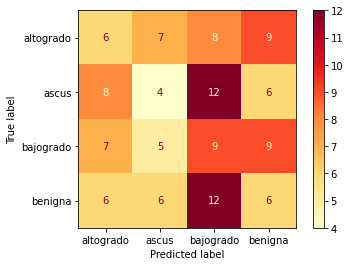

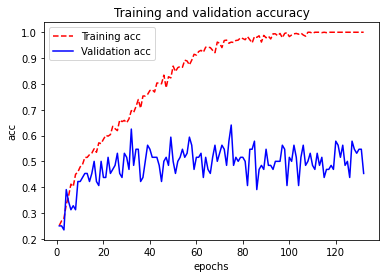

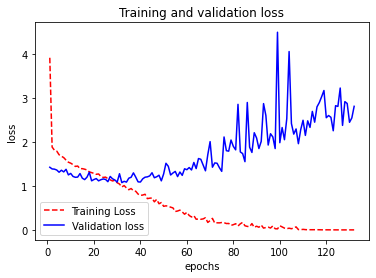

<Figure size 432x288 with 0 Axes>

In [14]:
history = model.fit(train_generator,epochs=600,validation_data=validation_generator,validation_steps=validation_steps, shuffle=False,class_weight=train_class_weights, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
calcularHistorial(model,history,validation_generator,test_generator,validation_steps)

120/120 [==============================] - 1s 5ms/step
0.225


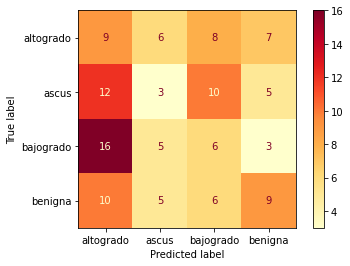

In [15]:
model.load_weights(filepath = '.mdl_wts.hdf5')
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)
class_names = list(validation_generator.class_indices.keys())
mostrarMatrizConf(test_predict,test_generator, class_names)

##Test 2

In [16]:
model = tf.keras.Sequential([
    layers.Conv2D(32, 3, padding="same", activation="relu",input_shape=(img_height,img_width,3)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.02),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.015),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.01),
    layers.Dense(4, activation ="sigmoid")
])

learning_rate=0.0001

model.compile(optimizer= keras.optimizers.RMSprop(learning_rate=learning_rate, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      36928     
                                                      

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min', min_delta =1e-4)
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=1, min_delta=1e-4, mode='min')

In [18]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes= np.unique(train_generator.classes), y= train_generator.classes )

train_class_weights = dict(enumerate(class_weights))

print(class_weights)
print(train_class_weights)

[1. 1. 1. 1.]
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


Epoch 1/450
21/21 [==============================] - 8s 325ms/step - loss: 1.7549 - accuracy: 0.2561 - val_loss: 1.5408 - val_accuracy: 0.2656 - lr: 1.0000e-04
Epoch 2/450
21/21 [==============================] - 7s 312ms/step - loss: 1.3796 - accuracy: 0.3186 - val_loss: 1.3364 - val_accuracy: 0.3594 - lr: 1.0000e-04
Epoch 3/450
21/21 [==============================] - 6s 306ms/step - loss: 1.2634 - accuracy: 0.3902 - val_loss: 1.2123 - val_accuracy: 0.4844 - lr: 1.0000e-04
Epoch 4/450
21/21 [==============================] - 7s 312ms/step - loss: 1.1817 - accuracy: 0.4756 - val_loss: 1.2064 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/450
21/21 [==============================] - 4s 159ms/step - loss: 1.1037 - accuracy: 0.5274 - val_loss: 1.3347 - val_accuracy: 0.3906 - lr: 1.0000e-04
Epoch 6/450
21/21 [==============================] - 7s 312ms/step - loss: 1.1129 - accuracy: 0.5290 - val_loss: 1.1626 - val_accuracy: 0.3906 - lr: 1.0000e-04
Epoch 7/450
21/21 [=====================

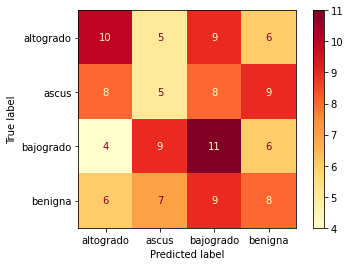

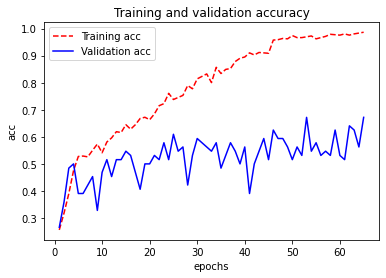

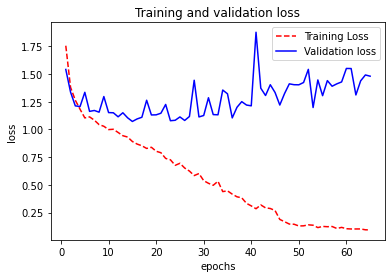

<Figure size 432x288 with 0 Axes>

In [19]:
history = model.fit(train_generator,epochs=450,validation_data=validation_generator,validation_steps=validation_steps, shuffle=False,class_weight=train_class_weights, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
calcularHistorial(model,history,validation_generator,test_generator,validation_steps)

120/120 [==============================] - 1s 5ms/step
0.20833333333333334


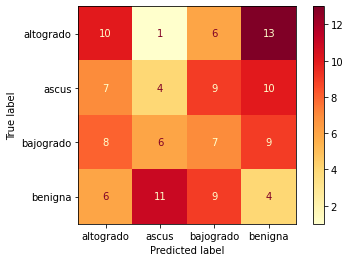

In [20]:
model.load_weights(filepath = '.mdl_wts.hdf5')
test_predict = model.predict(test_generator, steps = test_generator.n // 1, verbose =1)
class_names = list(validation_generator.class_indices.keys())
mostrarMatrizConf(test_predict,test_generator, class_names)

Vemos que usando tan pocas imagenes no se entrena bien el modelo, vamos a usar ahora todas las imagenes a ver como funciona.

Hemos comprobado tambien que el validation split era el problema.

##Test 3

#Webgrafía

Filas unicas en dataframe -> https://www.statology.org/pandas-unique-rows/ 

pandas groupby -> https://realpython.com/pandas-groupby/ 

pandas dataframe drop -> https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

pandas dataframe concat -> https://realpython.com/pandas-merge-join-and-concat/ 